### Library Management

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as R

# import tools for basic keras networks 
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

# supress unnecessary warnings throughout 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

### XOR Classification Problem

gensamples function generates random N samples from a 2D multivariate normal distribution:

mean:
[mx, my]

covariance matrix: 
[[  sx*sx, r*sx*sy],
[r*sx*sy,   sy*sy]]

sx: standard deviation along the x dimension

sy: standard deviation along the y dimension

r: the correlation between the dimensions

In [2]:
def gensamples(N, mx, my, sx, sy, r):
    M   = np.array([mx, my])
    Cov = np.array([[  sx*sx, r*sx*sy],
                    [r*sx*sy,   sy*sy]])
    return (R.multivariate_normal(M, Cov, size=N, check_valid='warn'))

#### XOR Classification Graph

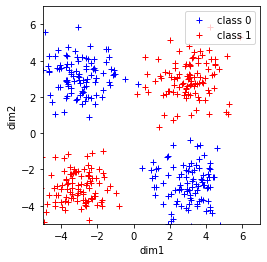

In [3]:
# classification problem used in Q1

# sample information from HW5
sx = 1. ; sy = 1.
r = 0.
N = 100

# new means for each category, through trial and error
mx0_1 = -3.;  my0_1 = 3.
mx0_2 = 3. ; my0_2 = -3.

mx1_1 = 3.; my1_1 = 3.
mx1_2 = -3.; my2_2 = -3.


# create 200 training patterns per category
sample0_1 = gensamples(N, mx0_1, my0_1, sx, sy, r)
sample0_2 = gensamples(N, mx0_2, my0_2, sx, sy, r)

sample1_1 = gensamples(N, mx1_1, my0_1, sx, sy, r)
sample1_2 = gensamples(N, mx1_2, my0_2, sx, sy, r)

# for use later in plottest function
sample0 = np.concatenate((sample0_1, sample0_2))
sample1 = np.concatenate((sample1_1, sample1_2))

# combine both samples in each class to make plotting easier, make code more concise
class0_x = np.concatenate((sample0_1[:,0], sample0_2[:,0]))
class0_y = np.concatenate((sample0_1[:,1], sample0_2[:,1]))

class1_x = np.concatenate((sample1_1[:,0], sample1_2[:,0]))
class1_y = np.concatenate((sample1_1[:,1], sample1_2[:,1]))

# plot example
plt.plot(class0_x, class0_y, 'b+', class1_x, class1_y, 'r+')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.axis('equal')
plt.axis('square')
plt.legend(('class 0', 'class 1'), loc='upper right')
xymin = -5; xymax = 7
plt.ylim((xymin,xymax))
plt.xlim((xymin,xymax))
plt.show()

# each plus sign is a training pattern, position on x and y axis is the position of the dimensions.
# feed 2d patterns to the network, use error driven learning to adjust the weights

#### Pattern Setup

In [4]:
training_pats = np.concatenate((sample0_1, sample0_2, sample1_1, sample1_2), axis = 0) # create training patterns array from above, with shape (400, 2)

class0 = np.zeros((200, 1)) # size of array is not hardcoded anywhere, must state it
class1 = np.ones((200, 1))

teacher_pats = np.concatenate((class0, class1), axis = 0)

# shuffling the patterns to avoid confusing the model during validation
shuffled_idx = R.permutation(training_pats.shape[0])
train_pats_shuffled = training_pats[shuffled_idx,:]
teach_pats_shuffled = teacher_pats[shuffled_idx,:]

n_in = training_pats.shape[1]  # returns 2, which is the number of inputs 
n_out = teacher_pats.shape[1]  # returns 1, which is the number of outputs

### XOR Network

In [5]:
nhid1 = 8  # number of nodes in hidden layer

network_q1 = models.Sequential()
network_q1.add(layers.Dense(nhid1, 
                         activation='sigmoid', 
                         input_shape=(n_in,)))  # present an additional layer
network_q1.add(layers.Dense(n_out,
                            activation = 'sigmoid'))

# print a model summary
print(network_q1.summary())
print()
for layer in network_q1.layers:
    print('layer name : {} | input shape : {} | output shape : {}'.format(layer.name, layer.input.shape, layer.output.shape))
print()
for layer in network_q1.layers:
    print(layer.get_config())
print()

# configure optimizer
sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9)  # stochastic gradient descent with provided parameters

# compile network
network_q1.compile(optimizer = sgd, 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', 'mse'])  # added accuracy metric for use later

# train the network
history = network_q1.fit(train_pats_shuffled, 
                      teach_pats_shuffled, 
                      verbose = True, 
                      validation_split = 0.20,
                      epochs = 100, 
                      batch_size = 20)  # same batch size from HW5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________
None

layer name : dense | input shape : (None, 2) | output shape : (None, 8)
layer name : dense_1 | input shape : (None, 8) | output shape : (None, 1)

{'name': 'dense', 'trainable': True, 'batch_input_shape': (None, 2), 'dtype': 'float32', 'units': 8, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer

#### **Architecture Analysis**

The way I approached this problem was by first trying to find the best number of hidden layers and nodes, then moving onto epochs and batch size.

Initially, I tried using 2 nodes within one hidden layer. This model was ineffective. The accuracy graph for this model was unstable and hit a horizontal asymptote of around 0.50.

I then increased the number of nodes to 8 in the single hidden layer. The model was even more variable in terms of accuracy, eventually leveling out to an accuracy of 0.50 again.

I then figured that maybe the model needs more epochs to make more adjustments and increase accuracy. I increased the epochs to 100, and saw that the model was able to reach almost 100% accuracy with more trials. While 100 epochs reaches a horizontal asymptote in loss by around 35 epochs, having the additional epochs allows for both the loss and validation loss to level out, which is ideal for the network.

In all honesty, I did not mess with the batch size or learning rate to any extent because the model was successful without doing so.

#### Visualizing Training Performance

Text(0.5, 1.0, 'Model Accuracy')

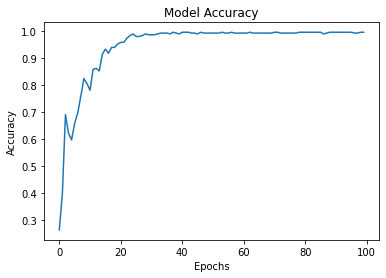

In [ ]:
epoch_list = np.arange(0, history.params['epochs'])  # creates an array of x values for each epoch
accuracy_list = history.history['accuracy']  # calls the accuracies from training the network above

#  Plot the data
plt.plot(epoch_list, accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

Text(0.5, 1.0, 'Model Accuracy')

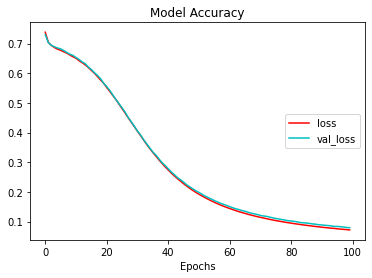

In [ ]:
loss_list = history.history['loss']
val_loss_list = history.history['val_loss']

plt.plot(epoch_list, loss_list, 'r', val_loss_list, 'c')  # plot both lists on the same graph
plt.legend(('loss', 'val_loss'), loc='center right')
plt.xlabel('Epochs')
plt.title('Model Accuracy')

Creation of test patterns

In [ ]:
# they will be evenly spaced along the x and y axes, making a lattice, or mesh 

xymin = -5
xymax = 7.5
Npts = 50
xv, yv = np.meshgrid(np.linspace(xymin, xymax, Npts), 
                     np.linspace(xymin, xymax, Npts))
test_pats = np.concatenate((xv.reshape((Npts*Npts,1)), 
                            yv.reshape((Npts*Npts,1))), axis=1)

In [ ]:
# xv is array of x-values of test grid (from meshgrid above)
# yv is array of y-values of test grid (from meshgrid above)
# out is the output of the neural network given the test patterns
# sample0, sample1 are the training patterns from earlier

def plottest(xv, yv, out, sample0, sample1):
    # reshape out
    zv = out.reshape(xv.shape)

    # create figure
    fig = plt.figure()
    plt.contourf(xv, yv, zv, levels=xv.shape[0], cmap=plt.cm.gist_yarg)
    plt.plot(sample0[:,0], sample0[:,1], 'b+', 
             sample1[:,0], sample1[:,1], 'r+')    
    
    plt.xlabel('dim1')
    plt.ylabel('dim2')
    plt.axis('equal')
    plt.axis('square')
    xymin = -5; xymax = 7.5
    plt.ylim((xymin,xymax))
    plt.xlim((xymin,xymax))
    plt.show()

79/79 [==============================] - 0s 808us/step


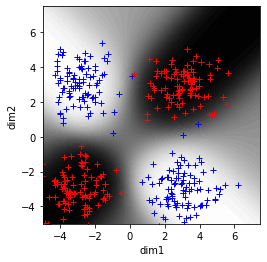

In [ ]:
out = network_q1.predict(test_pats)  # use notation, creates an array of outputs

plottest(xv, yv, out, sample0, sample1)  # use plottest function from above

### Non-XOR Classification Problem

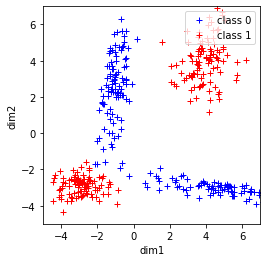

In [6]:
# classification problem used in Q1

# class 0 generation
mx0_1 = -1.;  my0_1 = 2.5
sx0_1 = 0.52 ;  sy0_1 = 2.

mx0_2 = 4.5 ; my0_2 = -3.
sx0_2 = 2.5; sy0_2 = 0.48

r0_1 = 0.5 ; r0_2 = -0.8

# class 1 generation
mx1_1 = -3.; my1_1 = -3.
sx1_1 = 0.9 ; sy1_1 = 0.5

mx1_2 = 4.; my1_2 = 4.
sx1_2 = 0.75 ; sy1_2 = 1.2

r1_1 = 0.1 ; r1_2 = 0.2


# create 200 training patterns per category
sample0_1 = gensamples(N, mx0_1, my0_1, sx0_1, sy0_1, r0_1)
sample0_2 = gensamples(N, mx0_2, my0_2, sx0_2, sy0_2, r0_2)

sample1_1 = gensamples(N, mx1_1, my1_1, sx1_1, sy1_1, r1_1)
sample1_2 = gensamples(N, mx1_2, my1_2, sx1_2, sy1_2, r1_2)

# for use later in plottest function, making all these variable concise
sample0 = np.concatenate((sample0_1, sample0_2))
sample1 = np.concatenate((sample1_1, sample1_2))

# combine both samples in each class to make plotting easier, make code more concise
class0_x = np.concatenate((sample0_1[:,0], sample0_2[:,0]))
class0_y = np.concatenate((sample0_1[:,1], sample0_2[:,1]))

class1_x = np.concatenate((sample1_1[:,0], sample1_2[:,0]))
class1_y = np.concatenate((sample1_1[:,1], sample1_2[:,1]))

# plot example
plt.plot(class0_x, class0_y, 'b+', class1_x, class1_y, 'r+')
plt.xlabel('dim1')
plt.ylabel('dim2')
plt.axis('equal')
plt.axis('square')
plt.legend(('class 0', 'class 1'), loc='upper right')
xymin = -5; xymax = 7
plt.ylim((xymin,xymax))
plt.xlim((xymin,xymax))
plt.show()

# each plus sign is a training pattern, position on x and y axis is the position of the dimensions.
# feed 2d patterns to the network, use error driven learning to adjust the weights

### Non-XOR Network

In [7]:
training_pats = np.concatenate((sample0_1, sample0_2, sample1_1, sample1_2), axis = 0) # create training patterns array from above, with shape (400, 2)

class0 = np.zeros((200, 1)) # size of array is not hardcoded anywhere, must state it
class1 = np.ones((200, 1))

teacher_pats = np.concatenate((class0, class1), axis = 0)

shuffled_idx = R.permutation(training_pats.shape[0])
train_pats_shuffled = training_pats[shuffled_idx,:]
teach_pats_shuffled = teacher_pats[shuffled_idx,:]

n_in = training_pats.shape[1]  # returns 2, which is the number of inputs 
n_out = teacher_pats.shape[1]  # returns 1, which is the number of outputs

In [8]:
# create architecture of simple neural network model (using tanh activation function here)

nhid1 = 4  # number of nodes in hidden layer

network_q5 = models.Sequential()
network_q5.add(layers.Dense(nhid1, 
                         activation='sigmoid', 
                         input_shape=(n_in,)))
network_q5.add(layers.Dense(n_out,
                            activation = 'sigmoid'))

# print a model summary
print(network_q5.summary())
print()
for layer in network_q5.layers:
    print('layer name : {} | input shape : {} | output shape : {}'.format(layer.name, layer.input.shape, layer.output.shape))
print()
for layer in network_q5.layers:
    print(layer.get_config())
print()

# configure optimizer
sgd = optimizers.SGD(learning_rate = 0.01, decay = 1e-6, momentum = 0.9)  # stochastic gradient descent with provided parameters

# compile network
network_q5.compile(optimizer = sgd, 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy', 'mse'])  # added accuracy metric for use later

# train the network
history = network_q5.fit(train_pats_shuffled, 
                      teach_pats_shuffled, 
                      verbose = True, 
                      validation_split = 0.20,
                      epochs = 100, 
                      batch_size = 15)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4)                 12        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________
None

layer name : dense_2 | input shape : (None, 2) | output shape : (None, 4)
layer name : dense_3 | input shape : (None, 4) | output shape : (None, 1)

{'name': 'dense_2', 'trainable': True, 'batch_input_shape': (None, 2), 'dtype': 'float32', 'units': 4, 'activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regul

#### **Architecture Analysis**

For this new classification problem, I began with 2 hidden layers and 100 epochs. The model failed to reach a horizontal asmympote and barely broke an accuracy of 0.9.

I then increased the number of hidden layers to 4. The model reached a horizontal asymptote quickly and got to an accuracy of 0.9844. Interesting.

Although the model was sufficient here, I continued testing. I increased the number of epochs from 100 to 150. There was little to no improvement in the accuracy of the model, indicating these extra epochs were redundant.

I then tried to change batch size. Increasing the batch size did not go well for the model. It did not get to a horizontal asymptote in accuracy in the same number of epochs. A reduced batch size of 15 landed me at near 100% accuracy. I decided to stick with it.

At this point I decided sufficiently classified the data. This was a brief overview of my process.

#### Visualizing Classification Decisions

Text(0.5, 1.0, 'Model Accuracy')

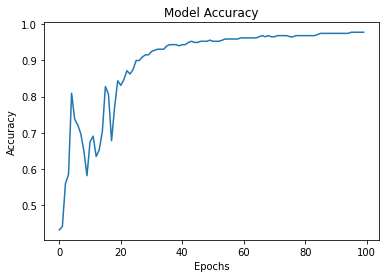

In [9]:
epoch_list = np.arange(0, history.params['epochs'])  # creates an array of x values for each epoch
accuracy_list = history.history['accuracy']  # calls the accuracies from training the network above

#  Plot the data
plt.plot(epoch_list, accuracy_list)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

Text(0.5, 1.0, 'Model Accuracy')

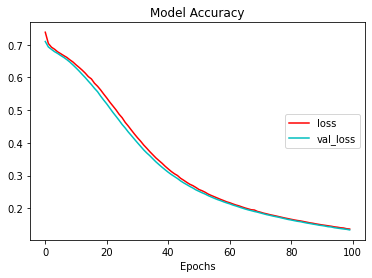

In [10]:
loss_list = history.history['loss']
val_loss_list = history.history['val_loss']

plt.plot(epoch_list, loss_list, 'r', val_loss_list, 'c')
plt.legend(('loss', 'val_loss'), loc='center right')
plt.xlabel('Epochs')
plt.title('Model Accuracy')

In [11]:
# this code will generate an array of test patterns for visualization
# they will be evenly spaced along the x and y axes, making a lattice, or mesh 

xymin = -5
xymax = 7.5
Npts = 50
xv, yv = np.meshgrid(np.linspace(xymin, xymax, Npts), 
                     np.linspace(xymin, xymax, Npts))
test_pats = np.concatenate((xv.reshape((Npts*Npts,1)), 
                            yv.reshape((Npts*Npts,1))), axis=1)

In [12]:
# xv is array of x-values of test grid (from meshgrid above)
# yv is array of y-values of test grid (from meshgrid above)
# out is the output of the neural network given the test patterns
# sample0, sample1 are the training patterns from earlier

def plottest(xv, yv, out, sample0, sample1):
    # reshape out
    zv = out.reshape(xv.shape)

    # create figure
    fig = plt.figure()
    plt.contourf(xv, yv, zv, levels=xv.shape[0], cmap=plt.cm.gist_yarg)
    plt.plot(sample0[:,0], sample0[:,1], 'b+', 
             sample1[:,0], sample1[:,1], 'r+')    
    
    plt.xlabel('dim1')
    plt.ylabel('dim2')
    plt.axis('equal')
    plt.axis('square')
    xymin = -5; xymax = 8
    plt.ylim((xymin,xymax))
    plt.xlim((xymin,xymax))
    plt.show()

79/79 [==============================] - 0s 1ms/step


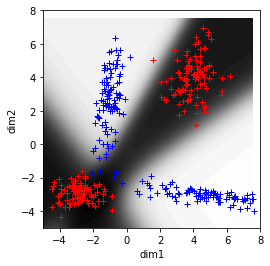

In [13]:
out = network_q5.predict(test_pats)  # use notation, creates an array of outputs

plottest(xv, yv, out, sample0, sample1)  # use plottest function from above

It is interesting to note the difference in the contour plot with a different number of hidden layers. The network produces differing results based on the settings of the layer, and these classification solutions can vary greatly. The classification problem even varies significantly when you run the same network multiple times.